In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import re
import ipywidgets as widgets
import random
import math
import os

from IPython.display import display, clear_output
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [2]:
def read_stitch_file(filepath):
    """
    Read StitchNodes output CSV as a pandas df
    
    Parameters
    ----------
    filepath : str
        Path to StitchNodes output CSV file
    
    Returns
    -------
    df_stitch : pandas.DataFrame
        DataFrame containing stitched tracks with a datetime column

    """
    df_stitch = pd.read_csv(filepath)
    df_stitch.columns = df_stitch.columns.str.strip() 
    df_stitch["datetime"] = pd.to_datetime(dict(year=df_stitch["year"], month=df_stitch["month"], day=df_stitch["day"], hour=df_stitch["hour"]))
    return df_stitch

def read_landfalling_file(filepath):
    """
    Read landfalling AR CSV as a pandas df
    
    Parameters
    ----------
    filepath : str
        Path to landfalling AR CSV file
    
    Returns
    -------
    df_landfalling : pandas.DataFrame
        DataFrame containing landfalling AR events with datetime columns

    """
    df_landfalling = pd.read_csv(filepath, skipinitialspace=True)
    df_landfalling["Start Date of AR"] = pd.to_datetime(df_landfalling["Start Date of AR"].astype(int), format="%Y%m%d%H")
    df_landfalling["End Date of AR"] = pd.to_datetime(df_landfalling["End Date of AR"].astype(int), format="%Y%m%d%H")
    df_landfalling['Longitude'] = df_landfalling['Longitude'] * -1
    return df_landfalling

def filter_stitched_by_landfalling(df_stitched, df_landfalling, overlap_threshold=0.75):
    """
    Filter stitched tracks to only those that exist during a landfalling AR event

    Parameters
    ----------
    df_stitched : pandas.DataFrame
        DataFrame containing stitched tracks with a datetime column
    df_landfalling : pandas.DataFrame
        DataFrame containing landfalling AR events with datetime columns
    overlap_threshold : float, optional
        Minimum fraction of overlap between track duration and landfalling AR duration 

    Returns
    -------
    df_stitched_new_filtered : pandas.DataFrame
        Filtered DataFrame of stitched tracks that meet the landfalling AR overlap threshold

    """
    # ensure df_stitched has a datetime column
    if 'datetime' not in df_stitched.columns and 'time' in df_stitched.columns:
        df_stitched['datetime'] = pd.to_datetime(df_stitched['time'], errors='coerce')
    elif 'datetime' in df_stitched.columns:
        df_stitched['datetime'] = pd.to_datetime(df_stitched['datetime'], errors='coerce')
    else:
        raise RuntimeError("df_stitched missing 'datetime' or 'time' column")

    min_dt, max_dt = df_stitched['datetime'].min(), df_stitched['datetime'].max()
    df_landfalling_small = df_landfalling[
        (df_landfalling['End Date of AR'] >= min_dt) &
        (df_landfalling['Start Date of AR'] <= max_dt)].copy()

    if df_landfalling_small.empty:
        print("No landfalling events overlap stitched time span")
        return df_stitched.iloc[0:0].copy()

    kept_ids = []
    for obj_id, group in df_stitched.groupby('track_id'):
        dt_vals = group['datetime'].dropna().sort_values()
        if dt_vals.empty:
            continue
        
        track_start = dt_vals.min()
        track_end = dt_vals.max()
        track_duration = (track_end - track_start).total_seconds()
        
        if track_duration == 0:
            # Single timestep track
            # Check if it falls within any AR
            for _, ar_row in df_landfalling_small.iterrows():
                if track_start >= ar_row['Start Date of AR'] and track_start <= ar_row['End Date of AR']:
                    kept_ids.append(obj_id)
                    break
            continue
        
        # Calculate total overlap with landfalling ARs
        total_overlap = 0
        for _, ar_row in df_landfalling_small.iterrows():
            ar_start = ar_row['Start Date of AR']
            ar_end = ar_row['End Date of AR']
            
            # Calculate overlap between track and this AR
            overlap_start = max(track_start, ar_start)
            overlap_end = min(track_end, ar_end)
            
            if overlap_start <= overlap_end:
                overlap_duration = (overlap_end - overlap_start).total_seconds()
                total_overlap += overlap_duration
        
        # Calculate overlap %
        overlap_fraction = total_overlap / track_duration
        
        if overlap_fraction >= overlap_threshold:
            kept_ids.append(obj_id)

    df_stitched_new_filtered = df_stitched[df_stitched['track_id'].isin(kept_ids)].copy()
    print(f"stitched span: {min_dt} to {max_dt}")
    print(f"landfall events considered: {len(df_landfalling_small)} (after filtering to stitched times)")
    print(f"kept unique track_ids: {len(kept_ids)} (overlap_threshold={overlap_threshold*100:.0f}%)")
    return df_stitched_new_filtered

In [3]:
df_stitch = read_stitch_file(r"C:\Users\Tony\Desktop\stitch_m3.0_r3p5_mt9h_mg1.csv")
df_stitch

,track_id,year,month,day,hour,i,j,lon,lat,pv_925,IVT,thetae_grad,tadv_925,tadv_925.1,z_500,fgen_925,fgen_925.1,shearing_def_925,shearing_def_925.1,datetime
0,0,2014,10,2,21,101,125,215.25,41.25,2.272121,1050.3640,17.929090,0.472871,0.575904,576.2903,-1.471918,-0.199291,19.56711,33.63505,2014-10-02 21:00:00
1,0,2014,10,3,0,107,131,216.75,42.75,2.347136,1209.1290,18.173740,-0.215357,0.439896,574.1180,0.382917,4.410977,23.78857,31.70893,2014-10-03 00:00:00
2,0,2014,10,3,3,116,138,219.00,44.50,2.339992,1235.5720,17.706680,-0.053848,0.476986,572.9106,1.715488,3.385112,18.13185,28.25685,2014-10-03 03:00:00
3,0,2014,10,3,6,125,145,221.25,46.25,2.260727,1200.4180,16.400610,-0.069921,0.369475,571.8009,1.802318,3.590682,22.26793,31.54498,2014-10-03 06:00:00
4,1,2014,10,13,0,114,130,218.50,42.50,1.315246,950.3074,16.470470,-0.690329,-0.158019,566.0111,1.127223,3.430342,13.75613,18.54352,2014-10-13 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,43,2015,9,24,0,139,129,224.75,42.25,3.081514,578.2225,17.226180,-1.289136,-0.571119,563.7858,0.658244,5.122473,11.96965,46.89180,2015-09-24 00:00:00
248,43,2015,9,24,3,147,134,226.75,43.50,2.877787,740.1049,14.150140,-0.432451,0.665893,562.4017,1.742662,4.630497,28.95766,41.84301,2015-09-24 03:00:00
249,43,2015,9,24,6,153,139,228.25,44.75,2.131084,627.1587,20.501070,-0.430303,0.703676,561.3871,0.391635,6.052977,18.21944,41.04912,2015-09-24 06:00:00
250,43,2015,9,24,9,160,145,230.00,46.25,2.543675,727.8555,13.732450,-0.116010,0.898338,560.3123,1.174492,3.219411,29.78555,47.72244,2015-09-24 09:00:00


In [4]:
df_landfalling = read_landfalling_file(r'C:\Users\Tony\Documents\GitHub\aware\preprocessing\landfalling_events\concatenated_landfalling_events.csv')
df_landfalling

,Start Date of AR,Date of maximum IVT magnitude,End Date of AR,Duration in hours,Maximum IVT magnitude,AR Scale,Average IVT magnitude,Direction of Maximum IVT magnitude,Average IVT direction,Maximum IWV,Average IWV,Average uIVT,Average vIVT,Latitude,Longitude
0,1959-10-07 20:00:00,1959100909,1959-10-11 14:00:00,91,708.43,3,436.751,273.548,272.934,36.54,30.3922,406.932,-20.85920,42.5,-124.5
1,1959-10-07 20:00:00,1959100907,1959-10-11 14:00:00,91,655.20,3,453.278,258.880,268.722,37.05,30.0284,420.995,9.39429,43.0,-124.5
2,1959-10-07 20:00:00,1959101108,1959-10-11 15:00:00,92,650.79,3,429.389,244.936,264.823,33.66,26.0158,398.598,36.11470,44.0,-124.0
3,1959-10-07 21:00:00,1959100901,1959-10-09 16:00:00,44,611.37,2,438.666,261.702,259.546,30.72,25.9982,405.288,74.77820,44.5,-124.0
4,1959-10-07 21:00:00,1959101109,1959-10-11 15:00:00,91,588.44,3,430.097,247.160,267.822,32.56,26.8096,403.530,15.34670,43.5,-124.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44280,2024-09-30 12:00:00,2024100100,2024-10-01 15:00:00,28,792.35,3,557.849,226.441,228.801,30.46,25.9143,418.120,366.02500,51.5,-128.0
44281,2024-09-30 13:00:00,2024100100,2024-10-01 13:00:00,25,770.54,3,554.868,219.857,220.917,29.34,24.4920,362.398,418.11300,52.5,-128.5
44282,2024-09-30 15:00:00,2024100111,2024-10-01 18:00:00,28,675.20,2,485.578,241.387,244.845,31.24,24.9068,436.817,205.13400,50.0,-127.0
44283,2024-09-30 18:00:00,2024100112,2024-10-01 19:00:00,26,660.56,2,456.623,247.697,252.168,29.17,22.6485,432.399,139.09100,49.5,-126.0


In [5]:
# Convert longitudes from 0-360 to -180-180 format BEFORE filtering
if 'lon' in df_stitch.columns and df_stitch['lon'].max() > 180:
    df_stitch['lon'] = df_stitch['lon'].apply(lambda x: x-360 if x > 180 else x)
    print("Converted df_stitch longitude to -180 to 180 format")

# Also convert landfalling AR longitudes if needed
lon_cols = [col for col in df_landfalling.columns if 'lon' in col.lower()]
if lon_cols:
    for col in lon_cols:
        if df_landfalling[col].max() > 180:
            df_landfalling[col] = df_landfalling[col].apply(lambda x: x-360 if x > 180 else x)
            print(f"Converted df_landfalling {col} to -180 to 180 format")

Converted df_stitch longitude to -180 to 180 format


In [6]:
filtered = filter_stitched_by_landfalling(df_stitch, df_landfalling, overlap_threshold=0.75)
filtered

stitched span: 2014-10-02 21:00:00 to 2015-09-24 12:00:00
landfall events considered: 758 (after filtering to stitched times)
kept unique track_ids: 27 (overlap_threshold=75%)


,track_id,year,month,day,hour,i,j,lon,lat,pv_925,IVT,thetae_grad,tadv_925,tadv_925.1,z_500,fgen_925,fgen_925.1,shearing_def_925,shearing_def_925.1,datetime
0,0,2014,10,2,21,101,125,-144.75,41.25,2.272121,1050.3640,17.929090,0.472871,0.575904,576.2903,-1.471918,-0.199291,19.56711,33.63505,2014-10-02 21:00:00
1,0,2014,10,3,0,107,131,-143.25,42.75,2.347136,1209.1290,18.173740,-0.215357,0.439896,574.1180,0.382917,4.410977,23.78857,31.70893,2014-10-03 00:00:00
2,0,2014,10,3,3,116,138,-141.00,44.50,2.339992,1235.5720,17.706680,-0.053848,0.476986,572.9106,1.715488,3.385112,18.13185,28.25685,2014-10-03 03:00:00
3,0,2014,10,3,6,125,145,-138.75,46.25,2.260727,1200.4180,16.400610,-0.069921,0.369475,571.8009,1.802318,3.590682,22.26793,31.54498,2014-10-03 06:00:00
4,1,2014,10,13,0,114,130,-141.50,42.50,1.315246,950.3074,16.470470,-0.690329,-0.158019,566.0111,1.127223,3.430342,13.75613,18.54352,2014-10-13 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,43,2015,9,24,0,139,129,-135.25,42.25,3.081514,578.2225,17.226180,-1.289136,-0.571119,563.7858,0.658244,5.122473,11.96965,46.89180,2015-09-24 00:00:00
248,43,2015,9,24,3,147,134,-133.25,43.50,2.877787,740.1049,14.150140,-0.432451,0.665893,562.4017,1.742662,4.630497,28.95766,41.84301,2015-09-24 03:00:00
249,43,2015,9,24,6,153,139,-131.75,44.75,2.131084,627.1587,20.501070,-0.430303,0.703676,561.3871,0.391635,6.052977,18.21944,41.04912,2015-09-24 06:00:00
250,43,2015,9,24,9,160,145,-130.00,46.25,2.543675,727.8555,13.732450,-0.116010,0.898338,560.3123,1.174492,3.219411,29.78555,47.72244,2015-09-24 09:00:00


Longitude range: -145.00° to -126.25°
Latitude range: 30.25°N to 52.25°N


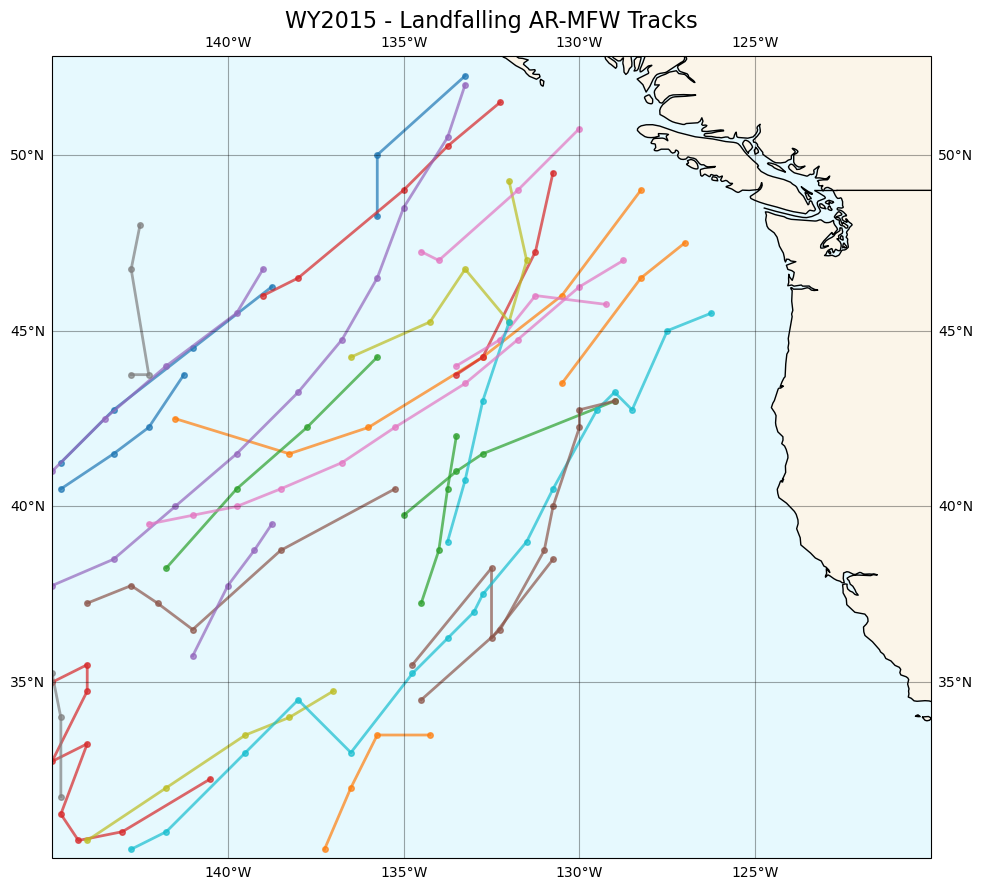

In [7]:
new_directions = {'North': 52.5, 'South': 30.0, 'East': 240.0, 'West': 215.0}

# Calculate and display max/min coordinates
print(f"Longitude range: {filtered['lon'].min():.2f}° to {filtered['lon'].max():.2f}°")
print(f"Latitude range: {filtered['lat'].min():.2f}°N to {filtered['lat'].max():.2f}°N")

fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={'projection': ccrs.PlateCarree()})

ax.set_extent([new_directions['West'], new_directions['East'], new_directions['South'], new_directions['North']])

ax.add_feature(cfeature.BORDERS)
ax.coastlines()
ax.add_feature(cfeature.LAND, color='#fbf5e9')
ax.add_feature(cfeature.OCEAN, color='#e6f9fe')

# Set gridlines with latitude every 5 degrees
gls = ax.gridlines(draw_labels=True, color='black', linestyle='-', alpha=0.35,
                   xlocs=range(-180, 181, 5), ylocs=range(-90, 91, 5))

# Plot each track separately
for track_id, track_data in filtered.groupby('track_id'):
    ax.plot(track_data["lon"], track_data["lat"], marker='o', linestyle='-', 
            markersize=4, linewidth=2, label=f"Track {track_id}", alpha=0.7)

lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()
gls.xformatter = lon_formatter
gls.yformatter = lat_formatter

plt.title("WY2015 - Landfalling AR-MFW Tracks", fontsize=16)
plt.tight_layout()
#plt.savefig("wy2015_tracks.png", dpi=300, bbox_inches='tight')
plt.show()

In [8]:
first_event = df_stitch[df_stitch['track_id'] == 1]
first_event

,track_id,year,month,day,hour,i,j,lon,lat,pv_925,IVT,thetae_grad,tadv_925,tadv_925.1,z_500,fgen_925,fgen_925.1,shearing_def_925,shearing_def_925.1,datetime
4,1,2014,10,13,0,114,130,-141.50,42.50,1.315246,950.3074,16.47047,-0.690329,-0.158019,566.0111,1.127223,3.430342,13.75613,18.54352,2014-10-13 00:00:00
5,1,2014,10,13,3,127,126,-138.25,41.50,1.829132,851.4069,20.63832,-0.933084,0.326100,572.4312,2.784976,5.188580,10.52759,19.12158,2014-10-13 03:00:00
6,1,2014,10,13,6,136,129,-136.00,42.25,2.377361,1085.5950,22.80771,-1.410547,0.098747,569.8956,1.369379,8.274896,16.86858,28.39976,2014-10-13 06:00:00
7,1,2014,10,13,9,149,137,-132.75,44.25,3.283538,960.5401,35.78997,-2.401173,0.231024,565.6544,11.770030,23.655910,51.29308,70.44846,2014-10-13 09:00:00
8,1,2014,10,13,12,158,144,-130.50,46.00,3.325636,964.2758,22.44457,-0.749806,0.577771,561.2127,5.449679,12.185730,39.21965,61.92387,2014-10-13 12:00:00
9,1,2014,10,13,15,167,156,-128.25,49.00,4.108239,756.6020,19.27693,0.106169,0.909025,554.9092,-0.487954,2.080350,55.02502,86.39217,2014-10-13 15:00:00


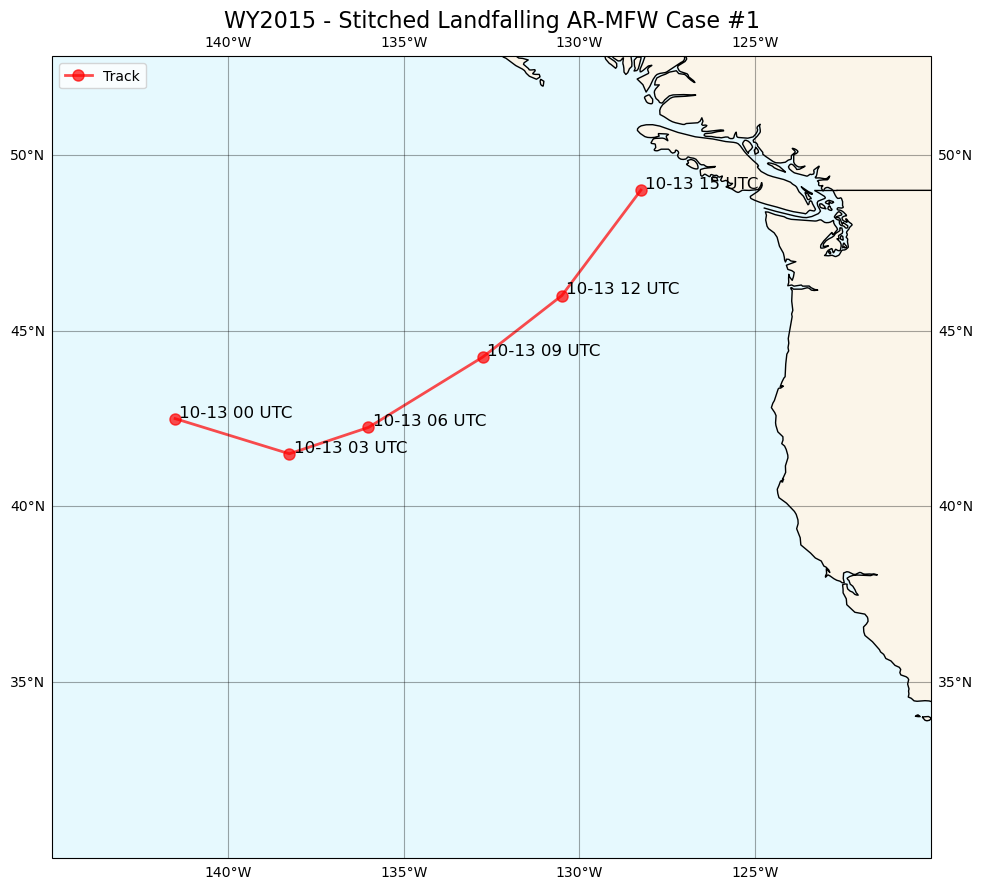

In [9]:
fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={'projection': ccrs.PlateCarree()})

ax.set_extent([new_directions['West'], new_directions['East'], new_directions['South'], new_directions['North']])

ax.add_feature(cfeature.BORDERS)
ax.coastlines()
ax.add_feature(cfeature.LAND, color='#fbf5e9')
ax.add_feature(cfeature.OCEAN, color='#e6f9fe')

gls = ax.gridlines(draw_labels=True, color='black', linestyle='-', alpha=0.35,
                   xlocs=range(-180, 181, 5), ylocs=range(-90, 91, 5))

ax.plot(first_event["lon"], first_event["lat"], marker='o', linestyle='-', 
        markersize=8, linewidth=2, label=f"Track", color='red', alpha=0.7)

# Annotate each point with its datetime
for _, row in first_event.iterrows():
    dt_val = row.get('datetime', None)
    if pd.notnull(dt_val):
        try:
            dt_str = pd.to_datetime(dt_val).strftime('%m-%d %H UTC')
        except Exception:
            dt_str = str(dt_val)
        ax.text(row['lon'] + 0.12, row['lat'] + 0.06, dt_str, fontsize=12, color='black', transform=ccrs.PlateCarree())

lon_formatter = LongitudeFormatter()
lat_formatter = LatitudeFormatter()
gls.xformatter = lon_formatter
gls.yformatter = lat_formatter

ax.legend(loc='upper left', frameon=True)
plt.title("WY2015 - Stitched Landfalling AR-MFW Case #1", fontsize=16)
plt.tight_layout()
#plt.savefig("wy2015_case1.png", dpi=300, bbox_inches='tight')

In [ ]:
# Interactive time evolution plot
new_directions = {'North': 52.5, 'South': 30.0, 'East': 240.0, 'West': 215.0}

# Get all unique timestamps and sort them
all_times = sorted(filtered['datetime'].unique())
print(f"Total timesteps: {len(all_times)}")
print(f"Time range: {all_times[0]} to {all_times[-1]}")

def plot_tracks_at_time(time_index):
    """Plot tracks up to a specific time index - only showing tracks active at current time"""
    current_time = all_times[time_index]
    
    # Get points at current time
    current_points = filtered[filtered['datetime'] == current_time]
    
    # Get track IDs that exist at current time
    active_track_ids = current_points['track_id'].unique()
    
    # Filter data up to current time, but only for active tracks
    data_so_far = filtered[
        (filtered['datetime'] <= current_time) & 
        (filtered['track_id'].isin(active_track_ids))
    ]
    
    fig, ax = plt.subplots(figsize=(14, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    
    ax.set_extent([new_directions['West'], new_directions['East'], 
                   new_directions['South'], new_directions['North']])
    
    ax.add_feature(cfeature.BORDERS)
    ax.coastlines()
    ax.add_feature(cfeature.LAND, color='#fbf5e9')
    
    # Set gridlines with latitude every 5 degrees
    gls = ax.gridlines(draw_labels=True, color='black', linestyle='-', alpha=0.35,
                       xlocs=range(-180, 181, 5), ylocs=range(-90, 91, 5))
    
    # Plot track history (faded) - only for tracks active at current time
    for track_id, track_data in data_so_far.groupby('track_id'):
        ax.plot(track_data["lon"], track_data["lat"], 
                linestyle='-', linewidth=2, alpha=0.4, label=f"Track {track_id}",
                transform=ccrs.PlateCarree())
    
    # Plot current positions (highlighted)
    if not current_points.empty:
        for track_id, track_data in current_points.groupby('track_id'):
            ax.plot(track_data["lon"], track_data["lat"], 
                    marker='o', markersize=12, markeredgewidth=2,
                    markeredgecolor='black', linestyle='', alpha=1.0,
                    transform=ccrs.PlateCarree())
    
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True)
    
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    gls.xformatter = lon_formatter
    gls.yformatter = lat_formatter
    
    plt.title(f"WY2015 - Landfalling AR-MFW Tracks\nTime: {current_time} (Step {time_index+1}/{len(all_times)})", 
              fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Create interactive slider
time_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(all_times)-1,
    step=1,
    description='Time Step:',
    continuous_update=False,
    layout=widgets.Layout(width='80%')
)

# Display interactive plot
widgets.interact(plot_tracks_at_time, time_index=time_slider)

Total timesteps: 137
Time range: 2014-10-02T21:00:00.000000000 to 2015-09-24T12:00:00.000000000


interactive(children=(IntSlider(value=0, continuous_update=False, description='Time Step:', layout=Layout(widt…

<function __main__.plot_tracks_at_time(time_index)>